# Text Classification using ULMFiT

Here we are going to prepare the classification model for classifying text as etiher **negative**, **positive** or **neutral** with the help of transfer learning. 

Since the text we are dealing with is in English we can use an already prepared language model to combine with our task. The structure of the text, language and semantic rules are same so it would save a lot of time and compute resources by using transfer learning rather than training model from scratch.

ULMFiT stands for Universal Language Model Fine-tuning and it is introduced by the `fastai` library.

It is well suited for tasks like text classification. Some of the benefits of using transfer learning are:

1. We don't have to train the model from scratch, so it saves time.
2. Similarly it saves compute resources.
3. It is a boon for small datasets. 
4. The accuracy obtaines is good.

<img src=https://nlp.fast.ai/images/ulmfit_imdb.png width=500>


We are not going to go in details of the ULMFiT model here but [here](http://nlp.fast.ai/) is amazing documentation and the [paper](https://arxiv.org/abs/1801.06146).


This the basic flow we are going to follow:

<img src=https://nlp.fast.ai/images/ulmfit_approach.png>


With this approach no domain, label or **preprocessing** is required. So we don't need to remove stopwords and punctuations(although it is a good practise to do so) becuase that might lead to loss of information or pattern. ULMFiT will handle semantics on it's own.







Uploading the dataset

In [ ]:
# Upload your Kaggle API in order to download the required dataset.
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

In [2]:
# Preparing the API for downloading
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [3]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 41.6MB/s]


In [4]:
!unzip /content/twitter-airline-sentiment.zip

Archive:  /content/twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [5]:
# importing the required libraries

import pandas as pd
import fastai
from fastai import *
from fastai.text import *

In [6]:
data=pd.read_csv('/content/Tweets.csv')

Although the distribution of labels here is unbalanced but it will be handled with transfer learning and ULMFiT. If were using a simpler classification model we would need to balance the data first.

In [7]:
#checking the distribution of labels
data.shape
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Picking only the `text` and `airline sentiment` from the data.

In [8]:
data=data[['airline_sentiment','text']]
data.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


### Splitting the data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

#dropping null values
data.dropna(inplace=True)

# split data into training and validation set
df_trn, df_val = train_test_split(data, stratify = data['airline_sentiment'], test_size = 0.2, random_state = 12)

In [11]:
#checking the shape of training and validation set

df_trn.shape, df_val.shape

((11712, 2), (2928, 2))

### Data for Language Model

`TextLMBunch` will apply some preprocessing tasks. Thus we don't need to do preprocessing here.

In [12]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

This is how the tokens are created. The `xx...` here hold special meaning and pattern which will help the network to learn.

More information [here](https://docs.fast.ai/text.transform.html).

In [13]:
data_lm.train_ds.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [14]:
# the idx is the position relative to which the text is stored
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"amazing ! ! ! xxup you xxup are xxup the xxup best ! ! ! xxup follow xxup me xxup please 🙏 🙏 🙏 😢 😢 😢 🙏 🙏 🙏 xxbos @southwestair would be great if i atleast was next to my husband who is flying in the same reservation xxbos @united oh no , i 'm rebooked , 7 + hours after my original arrival time . xxmaj we"
1,been sitting at xxup lga for 20 hours and no call from you to xxunk or delivery of bag . xxup bad xxbos @usairways color me confused but why would i need to call and do this . xxmaj update your procedures and policies . xxmaj you can see who is connecting xxbos @usairways any updates on flight xxunk from xxup orf to xxup phl no one at gate ...
2,@british_airways xxbos xxmaj decisions xxmaj decisions @mandarinjourney @united : xxmaj we 'd love for you to try our service . xxmaj we offer status match too . http : / / t.co / xxunk xxup ^kp ” xxbos @united xxup xxunk xxup iah - > xxup sjo is delayed by like 1.5 hours . xxmaj crazy ! xxbos @southwestair is xxmaj america 's xxunk airline by passengers carried ! xxmaj
3,"rebook me on another airline . # disappointed xxbos @jetblue sorry , should have specified i meant ground traffic trying to get into the terminal xxbos @united this flight has been amazing . xxmaj this is the best flight i have ever been on i am not kidding . xxmaj service is xxup incredible ! xxbos @usairways an already pleasant flight from xxmaj london to xxmaj charlotte ( xxup xxunk"
4,delays # typical xxbos @southwestair i have a flight on xxmaj sunday the 22nd to xxmaj columbus from xxmaj denver . i just got a travel alert on my southwest app . xxmaj is the rescheduling xxbos @southwestair yeah they told me it would be on the next flight . i drove down and it was nt . i just drove down for a second time and they were xxbos


### Creating the Language Model

Using `pretrained=True` will let us load the pretrained model with with we don't need to train the model from scratch.
We are downloading the weights from the pretrained model.

In [15]:
# create LM
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

# Fine Tuning Language Model


The step-1 of utilizing the ULMFiT is to fine tune the langauge model.
Here `lr_find` helps to find the optimal learning rate. 

The plot for the same is outputted by `lang_mod.recorder.plot(suggestion=True)`.


We will follow these steps:

- We are going to find the best learning rate (LR)
- Adjust the last layer with the `fit_one_cycle`
- Unfreeze all the layers
- Find the new learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 6.31E-02


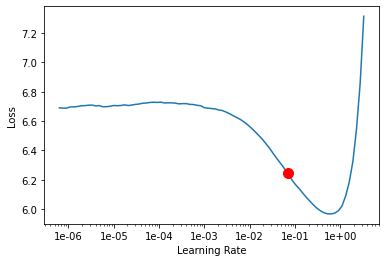

In [16]:
lang_mod.lr_find()
lang_mod.recorder.plot(suggestion=True)

Then we will train our model for 5 epochs, using the `fit_one_cycle` function. With this we will train, by now, only the last layer of our language model.

In [17]:
lang_mod.fit_one_cycle(5, max_lr= 5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.993836,4.032992,0.248354,00:24
1,4.427549,4.017935,0.253544,00:24
2,4.177373,3.945390,0.261300,00:24
3,3.948277,3.873075,0.269838,00:24
4,3.754862,3.854152,0.273172,00:24


We can continue to train the language model by gradually unfreezing some layers at a time. But the learning rate with each layer should be altered accordingly.


In [18]:
#unfreezing one layer
lang_mod.freeze_to(-1)

Finding optimal learning rate again.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04
Min loss divided by 10: 2.75E-03


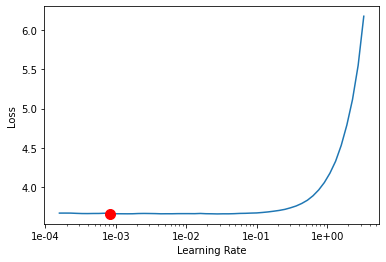

In [19]:
lang_mod.lr_find()
lang_mod.recorder.plot(skip_start=40, suggestion=True)

In [21]:
# train the language model
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.660519,3.849159,0.273465,00:24
1,3.648696,3.844141,0.273884,00:24
2,3.639591,3.843107,0.274289,00:24


We can see that the train and valid loss are lower and less overfitted with high accuracy.

## Same thing by unfreezing one more layer

In [22]:
lang_mod.freeze_to(-2)
lang_mod.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03
Min loss divided by 10: 9.12E-04


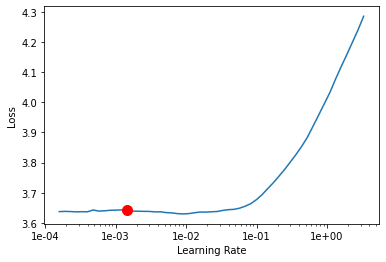

In [23]:
lang_mod.recorder.plot(skip_start=40, suggestion=True)

In [24]:
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.630772,3.818035,0.276451,00:25
1,3.597192,3.800977,0.279269,00:25
2,3.572498,3.799707,0.279297,00:25


# Last unfreeze

In [25]:
lang_mod.unfreeze()
lang_mod.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-03
Min loss divided by 10: 5.25E-04


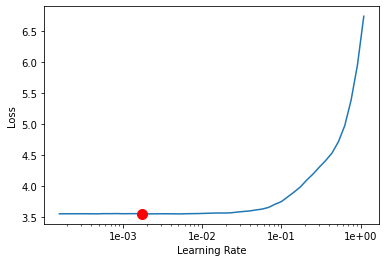

In [26]:
lang_mod.recorder.plot(skip_start=40, suggestion=True)

In [27]:
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.543928,3.780780,0.281417,00:31
1,3.504888,3.764264,0.284807,00:31
2,3.463095,3.764375,0.284863,00:31


In [28]:
#saving the langauge model
lang_mod.save_encoder('Encoder')

The language model is ready and this will be used for the classification. Let's move onto step-2 of our task that is **Classification**.

# Classification Model

In [29]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [30]:
data_clas.show_batch()

text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
xxbos @americanair xxmaj took a flight yesterday fron xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,negative
xxbos @usairways xxup you xxup are xxup amazing ! ! ! xxup you xxup are xxup the xxup best ! ! ! xxup follow xxup me xxup please xxup and i xxup follow xxup you xxup xxunk 🙏 🙏 🙏 ✌ ️ 😉 ),positive


Creating the classifier by passing the classifier model data.

In [31]:
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

Loading the saved langauge model.

In [32]:
learn_classifier.load_encoder('Encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos @americanair thanks for getting back to me . how xxunk are these weather advisories updated throughout the day ?,xxbos @united love the new 1st class breakfast !,xxbos @united sitting in xxmaj denver airport waiting for a plane to be xxunk . xxmaj for an hour and a half ! xxmaj hurry the fuck up xxmaj united , you fucking xxunk,xxbos @usairways xxup you xxup are xxup amazing ! ! ! xxup you xxup are xxup the xxup best ! ! ! xxup follow xxup me xxup please 🙏 🙏 🙏 😢 😢 😢 🙏 🙏 🙏,xxbos @southwestair would be great if i atleast was next to my husband who is flying in the same reservation
y: CategoryList
neutral,positive,negative,positive,negative
Path: .;

Valid: LabelList (2928 items)
x: TextList
xxbos @united i 'm not sure you can do anything as this has been xxunk up over time ! xxmaj other than promises from your xxup ceo service has gotten worse !,xxbos # xxmaj real xxup rt @jetblue : xxmaj our fleet 's on

 Similar to what we did with the language model, we are going to find the best learning rate (LR), adjust the last layer with the `fit_one_cycle`, unfreeze all the layers and find the new learning rate.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.51E-02


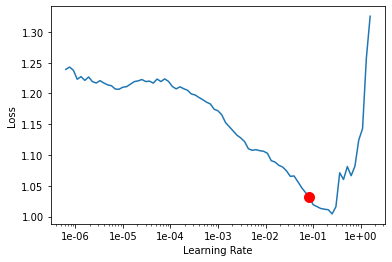

In [33]:
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [34]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.722661,0.600620,0.766052,00:20
1,0.689582,0.599000,0.765710,00:20
2,0.662065,0.574459,0.773224,00:21
3,0.677969,0.555712,0.776639,00:21
4,0.639005,0.549036,0.786885,00:20


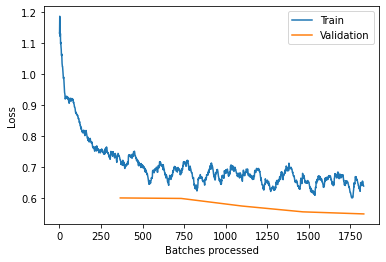

In [35]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.10E-07


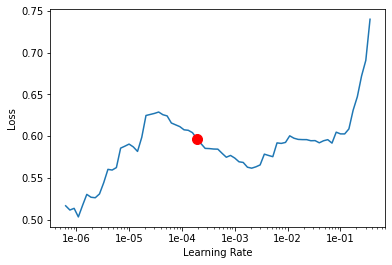

In [36]:
#Unfreezing another layer
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Let's test the classifier with some text. For that we are going to use the `predict` function.

- Category 0: Negative
- Category 1: Neutral
- Category 2: Positive

In [37]:
learn_classifier.predict('I loved the service. Cant wait to travel with you guys again :)')

(Category tensor(2), tensor(2), tensor([0.3620, 0.0958, 0.5422]))

In [38]:
learn_classifier.predict('Worst service ever. I am going to sue you')

(Category tensor(0), tensor(0), tensor([0.9007, 0.0373, 0.0620]))

Storing the prediction for validation set.

In [39]:
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([2928, 3])

Ratio per predicted class.

In [40]:
preds=valid_preds.numpy()
print(np.mean(preds[:,0]))
print(np.mean(preds[:,1]))
print(np.mean(preds[:,2]))

0.5958492
0.20865269
0.19549811


Creating the dataframe

In [41]:
df_val_pred=pd.DataFrame({'text':df_val.text, 'target':df_val.airline_sentiment, 'pred_target':valid_label})

We will create a function `label_pred` to map numerical predictions to categories.

In [42]:
def label_pred (row):
   if row['pred_target'] == 0 :
      return 'negative'
   if row['pred_target'] == 1:
      return 'neutral'
   else:
      return 'positive'
  

In [43]:
df_val_pred['pred_target']=df_val_pred.apply(lambda row: label_pred(row), axis=1)
df_val_pred.head()

,text,target,pred_target
1280,@united I'm not sure you can do anything as th...,negative,negative
7008,#Real RT @JetBlue: Our fleet's on fleek. http:...,neutral,neutral
13683,@AmericanAir we will not be flying with you or...,negative,negative
8659,@JetBlue credit to you for replying. I’ll loo...,positive,positive
5565,@SouthwestAir @TheEllenShow @Imaginedragons if...,neutral,neutral


The distribution of predicted sentiments.

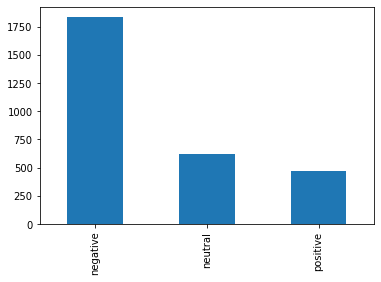

In [45]:
df_val_pred.pred_target.value_counts().plot.bar()

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(df_val.airline_sentiment,df_val_pred.pred_target)

array([[1836,    0,    0],
       [   0,  620,    0],
       [   0,    0,  472]])

In [48]:
accuracy_score(df_val.airline_sentiment,df_val_pred.pred_target)

1.0

The accuracy score of 1.0 looks a bit suspicious but after testing the classifier with unseen data it seems like the classifier is able to classify the text well and transfer learning with ULMFiT has helped acheiving this accuracy. Before completing the notebook let's classify some more unseen text.

In [49]:
learn_classifier.predict('United is thw worst airline. I want to urge all the passengers to never book your flights with them')

(Category tensor(0), tensor(0), tensor([0.9179, 0.0581, 0.0240]))

In [51]:
learn_classifier.predict('Virgin America is an airline I can trust anyday. I have been travelling with them for 5 years now.')

(Category tensor(2), tensor(2), tensor([0.2739, 0.1393, 0.5868]))

See ^ classifer predicted the category correctly for both the negative and positive sentiments.